## Case Study - Data visualization

### Getting started

As you did in the data ingestion case study download the following notebook and the necessary data then open the notebook locally or a part of your project on Watson Studio.

* [m2-u4-case-study.ipynb](m1-u6-case-study.ipynb)
* [m4-u4-case-study-solution.ipynb](./notebooks/m2-u4-case-study-solution.ipynb)
* [aavail-customers.db](./data/aavail-customers.db)
* [aavail-steams.csv](./data/aavail-streams.csv)

### Build a deliverable

Recall that you are trying to identify the factors that contribute to the unique market situation in Singapore.  Singapore has a higher rate of churn than the other markets and there is something in the data that, once uncovered, will allow you to make a hypothesis.  

Your deliverable is a storyboard.  The story should begin with descriptions of the data along with a summary of the business opportunity.  The rest of the story details the process of your investigation and puts into context your findings.  Finally, you should end with some discussion and suggestions about next steps in the process.

Possible formats for your deliverable:

**Slideshow**

   * [Jupyter notebooks to slides with RISE](https://github.com/damianavila/RISE)
   * [Beamer](http://ctan.mirrors.hoobly.com/macros/latex/contrib/beamer/doc/beameruserguide.pdf) using $\LaTeX$
   * [LibreOffice](https://www.libreoffice.org)
  
**Reports**

   * [nbconvert](https://nbconvert.readthedocs.io/en/latest)
   * [PDF reports from plotly](https://plot.ly/python/v3/pdf-reports)
   * [PDF or HTML reports from Jinja2](http://www.marknagelberg.com/creating-pdf-reports-with-python-pdfkit-and-jinja2-templates/)
   
If you have not given it a try, RISE is a powerful and professional presentation tool.  It is outside of the scope of this content, but [this video from last year's jupytercon](https://www.youtube.com/watch?v=Gx2TnIdt0hw) is great place to start if you want to learn more.

### Expectations

That you build a deliverable either in slideshow or report form to accomplish the following:

1. Use a data ingestion script that readily accepts more data in batch form
2. Explicitly identify and handle missing values at the level of data ingestion
3. Visual summaries that detail the data (including the number of missing value, columns dropped etc)
4. **Through *investigative visualization* identify the factor or factors that explain the Singapore situation**.
5. At a minimum one line descriptions should be used for each plot and table
6. Conclustions and discussion about next steps

If the deliverable is a presentation it is reasonable to assume that 30 minutes would be enough time to cover the materials.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import getopt
import scipy.stats as stats
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import OneHotEncoder

DATA_DIR = os.path.join('.', 'data')

In [2]:
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams.csv

...successfully connected to db
... removed 7 duplicate rows in db data
... removed 1164 missing stream ids
done


In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, 'aavail-target.csv'))
df.head()

,customer_id,is_subscriber,country,gender,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,m,21,Kasen Todd,aavail_premium,23
1,2,0,singapore,f,30,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,f,22,Lillian Carey,aavail_premium,22
3,4,1,united_states,m,21,Beau Christensen,aavail_basic,19
4,5,1,singapore,m,21,Ernesto Gibson,aavail_premium,23


## Add one-hot encoded columns for gender, subscriber_type and country

In [4]:
df = pd.concat([df, pd.get_dummies(df['gender']), pd.get_dummies(df['country']), pd.get_dummies(df['subscriber_type'])], axis=1)
df = df.rename(columns = {'m': 'male', 'f': 'female'})
df.head()

,customer_id,is_subscriber,country,gender,age,customer_name,subscriber_type,num_streams,female,male,singapore,united_states,aavail_basic,aavail_premium,aavail_unlimited
0,1,1,united_states,m,21,Kasen Todd,aavail_premium,23,0,1,0,1,0,1,0
1,2,0,singapore,f,30,Ensley Garza,aavail_unlimited,12,1,0,1,0,0,0,1
2,3,0,united_states,f,22,Lillian Carey,aavail_premium,22,1,0,0,1,0,1,0
3,4,1,united_states,m,21,Beau Christensen,aavail_basic,19,0,1,0,1,1,0,0
4,5,1,singapore,m,21,Ernesto Gibson,aavail_premium,23,0,1,1,0,0,1,0


## How are different countries performing in terms of subscribers

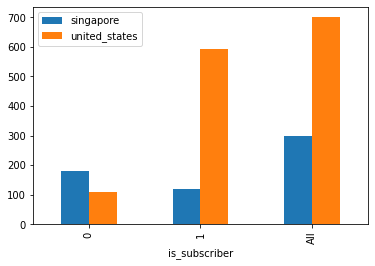

In [5]:
countries = ['united_states', 'singapore']
pd.pivot_table(df, index=['is_subscriber'], values=countries, aggfunc=sum, margins=True).plot(kind='bar')

Haha, US has more subscribers and fewer non-subscribers than Singapore. Surprise surprise.

## Look at number of streams and age relative to subscriber status and country

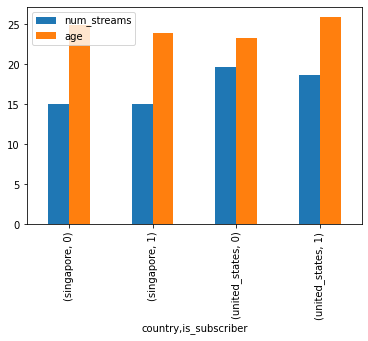

In [6]:
df.groupby(['country', 'is_subscriber'])['num_streams', 'age'].mean().plot(kind='bar')

Age doesn't vary too much. US users do actually use the service quite a bit more, as measured by number of streams. Interesting that non-subscribers use a bit more than subscribers.

## Any relation to gender?

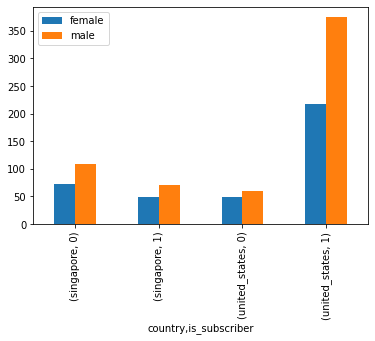

In [7]:
genders = ['female', 'male']
df.groupby(['country', 'is_subscriber'])['female', 'male'].sum().plot(kind='bar')

This may be interesting. US has about 2x male subscribers to female subscribers. Might be useful in planning marketing programs.

## Plot subscription type  vs subscriber status and country

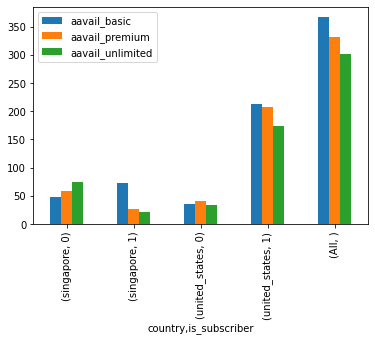

In [8]:
subscriber_types = ['aavail_basic', 'aavail_premium', 'aavail_unlimited']
pd.pivot_table(df, index=['country', 'is_subscriber'], values=subscriber_types, aggfunc=sum, margins=True).plot(kind='bar')

Singapore has many more basic subscribers thank premium subscribers, and premium subscribers seem to churn at a higher rate than basic. In US, the sub types seem to churn about equally, and premium sub uptake is a bit more equal.

In [14]:
# Create a new temporary dataframe to help us plot these variables.
pd.melt(df, id_vars=['is_subscriber'], value_vars=["country"], var_name='country' )

# pd.concat([df['is_subscriber'], df['country']])

# # Create a factorplot
# g = sns.factorplot( x="country", y="is_subscriber", hue='value', data=df1, size=4, aspect=2, kind="bar", palette="husl", ci=None )
# g.despine(left=True)
# g.set_ylabels("Is_Subscriber")
# plt.show()

,is_subscriber,country,value
0,1,country,united_states
1,0,country,singapore
2,0,country,united_states
3,1,country,united_states
4,1,country,singapore
...,...,...,...
995,0,country,singapore
996,1,country,united_states
997,1,country,united_states
998,1,country,united_states


In [20]:
df[['is_subscriber', 'country']]

,is_subscriber,country
0,1,united_states
1,0,singapore
2,0,united_states
3,1,united_states
4,1,singapore
...,...,...
995,0,singapore
996,1,united_states
997,1,united_states
998,1,united_states
